In [22]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

In [2]:
# Enable GPU memory growth to prevent overflow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Define dataset path
DATA_DIR = "/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES"
IMG_SIZE = 224
BATCH_SIZE = 32

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values (0 to 1)
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2  # 20% for validation
)

val_datagen = ImageDataGenerator(
    rescale=1./255,  # No augmentation for validation
    validation_split=0.2
)


In [9]:
train_generator =train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 21726 images belonging to 10 classes.


In [10]:
print(train_generator.class_indices)

{'1. Eczema 1677': 0, '10. Warts Molluscum and other Viral Infections - 2103': 1, '2. Melanoma 15.75k': 2, '3. Atopic Dermatitis - 1.25k': 3, '4. Basal Cell Carcinoma (BCC) 3323': 4, '5. Melanocytic Nevi (NV) - 7970': 5, '6. Benign Keratosis-like Lesions (BKL) 2624': 6, '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 7, '8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 8, '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 9}


In [11]:

val_generator =val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 5427 images belonging to 10 classes.


In [12]:

# Enable memory growth for all GPUs
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)


In [15]:
# Load base model
from tensorflow.keras.applications import EfficientNetB3
base_model = EfficientNetB3(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers - let's try unfreezing the last 50 layers
for layer in base_model.layers[-50:]:
    layer.trainable = True


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Add custom classification layers with more regularization
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Increased dropout

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)


In [19]:
output = Dense(train_generator.num_classes, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)


In [20]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


In [23]:
checkpoint = ModelCheckpoint("best_model.keras", 
                            save_best_only=True, 
                            monitor='val_accuracy',  # Changed to val_accuracy
                            mode='max', 
                            verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy',  # Changed to val_accuracy
                             patience=10,  # Increased patience
                             restore_best_weights=True,
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=3,
                             min_lr=1e-7,
                             verbose=1)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[checkpoint, early_stopping],
)



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.3951 - loss: 1.9040
Epoch 1: val_accuracy improved from -inf to 0.31933, saving model to best_model.keras
679/679 ━━━━━━━━━━━━━━━━━━━━ 904s 1s/step - accuracy: 0.3953 - loss: 1.9033 - val_accuracy: 0.3193 - val_loss: 2.4060
Epoch 2/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.6427 - loss: 0.9697
Epoch 2: val_accuracy improved from 0.31933 to 0.52663, saving model to best_model.keras
679/679 ━━━━━━━━━━━━━━━━━━━━ 418s 610ms/step - accuracy: 0.6427 - loss: 0.9696 - val_accuracy: 0.5266 - val_loss: 1.4052
Epoch 3/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7032 - loss: 0.7898
Epoch 3: val_accuracy improved from 0.52663 to 0.55242, saving model to best_model.keras
679/679 ━━━━━━━━━━━━━━━━━━━━ 411s 599ms/step - accuracy: 0.7033 - loss: 0.7898 - val_accuracy: 0.5524 - val_loss: 1.3222
Epoch 4/15
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.7404 - loss: 0.6999
Epoch 4: val_accuracy improved from

In [25]:
# Save the model after training
model.save('skin_disease_detection_model.h5')


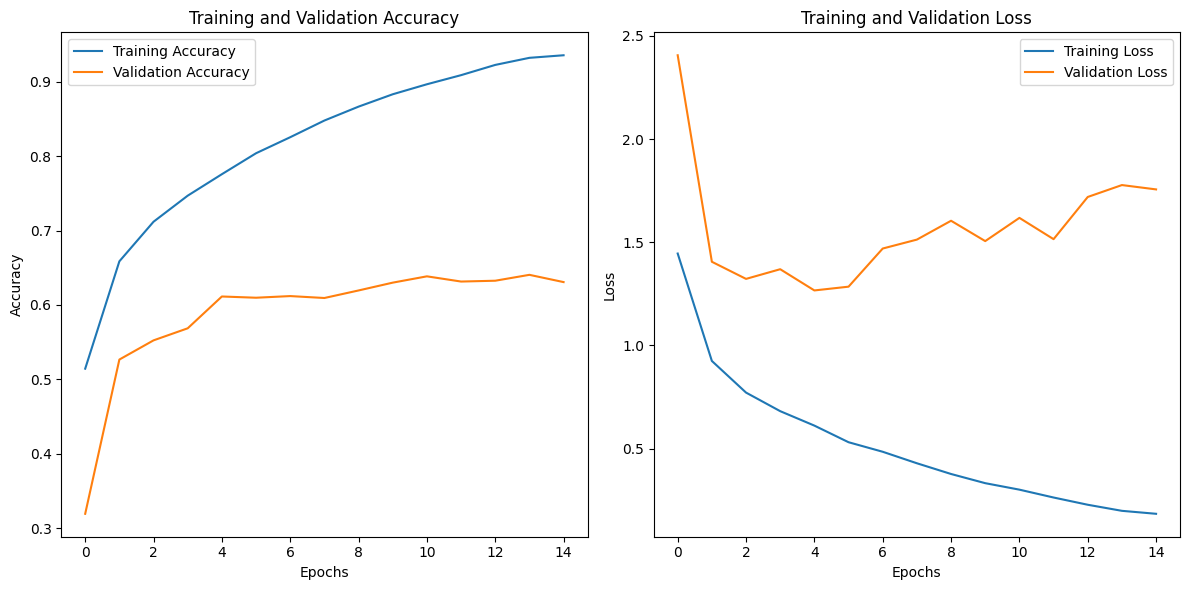

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()